In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import PowerLaw, SpectralModel
from gammapy.utils.modeling import Parameter, ParameterList

## simulate a powerlaw observation

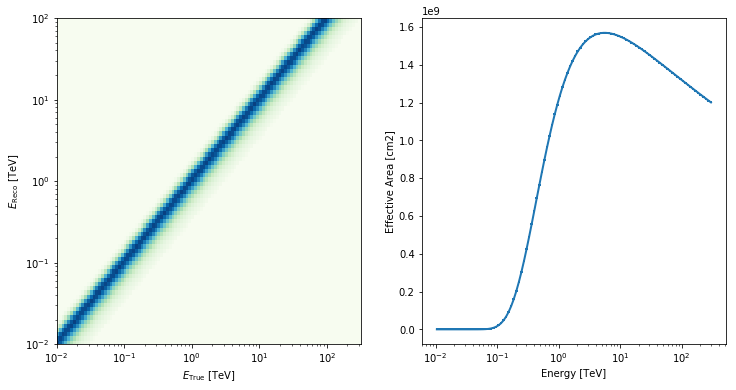

In [2]:
# define the IRFs
e_true = np.logspace(-2, 2.5, 109) * u.TeV
e_reco = np.logspace(-2,2, 79) * u.TeV

edisp = EnergyDispersion.from_gauss(e_true=e_true, e_reco=e_reco, sigma=0.2, bias=0)
aeff = EffectiveAreaTable.from_parametrization(energy=e_true)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
edisp.plot_matrix(ax=axes[0])
aeff.plot(ax=axes[1])

In [32]:
# define the model
index = 2.5 * u.Unit('')
amplitude = 2e-11 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

# define the background model
bkg_index = 3 * u.Unit('')
bkg_amplitude = 3e-12 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

pwl = PowerLaw(index=index, amplitude=amplitude, reference=reference)
bkg_model = PowerLaw(index=bkg_index, amplitude=bkg_amplitude, reference=reference)
alpha = 0.3

livetime = 10 * u.min

In [43]:
n_obs = 1
seeds = np.arange(n_obs)

sim = SpectrumSimulation(aeff=aeff,
                         edisp=edisp,
                         source_model=pwl,
                         livetime=livetime,
                         background_model=bkg_model,
                         alpha=alpha)

sim.run(seeds)
print(sim.result)
print(sim.result[0])

SpectrumObservationList
Number of observations: 1
*** Observation summary report ***
Observation Id: 0
Livetime: 0.167 h
On events: 75
Off events: 50
Alpha: 0.300
Bkg events in On region: 15.00
Excess: 60.00
Excess / Background: 4.00
Gamma rate: 6.00 1 / min
Bkg rate: 0.02 1 / min
Sigma: 8.83
energy range: 0.01 TeV - 100.00 TeV


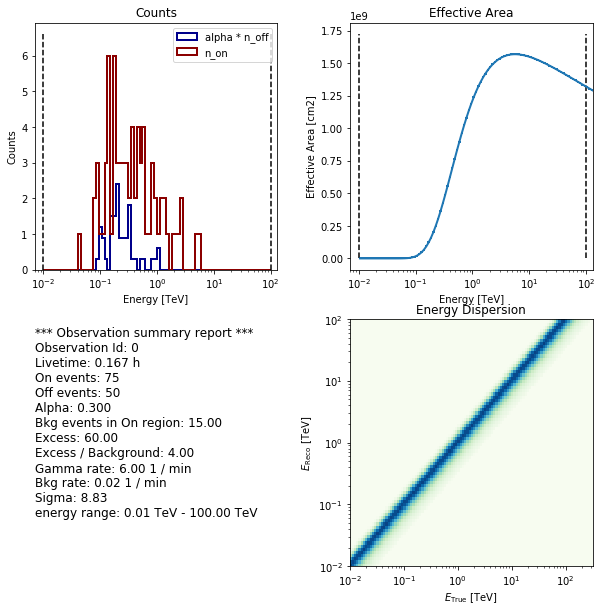

In [44]:
sim.obs.peek()

In [45]:
fit = SpectrumFit(obs_list=sim.obs, model=pwl.copy(), stat='wstat', method='iminuit', err_method='iminuit')
fit.fit_range = [1e-2, 1e2] * u.TeV
fit.fit()
fit.est_errors()
print(fit.result[0])

/Users/Kai/Development/gammapy/gammapy/utils/fitting/iminuit.py:44: InitialParamWarning: errordef is not given. Default to 1.
  **minuit_kwargs)
/Users/Kai/Development/gammapy/gammapy/utils/fitting/iminuit.py:44: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.
  **minuit_kwargs)
/Users/Kai/Development/gammapy/gammapy/utils/fitting/iminuit.py:44: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
  **minuit_kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


FCN = 42.4181621959363 
 TOTAL NCALL = 88 
 NCALLS = 88 
 
 
 EDM = 2.3164871858506196e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,index,2.5852,0.210026,0,0,,,
2,amplitude,1.78203e-11,4.12088e-12,0,0,,,
3,reference,1,1,0,0,,,FIXED



Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit      min max frozen
	--------- --------- --------- --------------- --- --- ------
	    index 2.586e+00 2.100e-01                 nan nan  False
	amplitude 1.785e-11 4.121e-12 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00 0.000e+00             TeV nan nan   True

Covariance: 

	name/name   index   amplitude
	--------- --------- ---------
	    index    0.0441 -6.72e-13
	amplitude -6.72e-13   1.7e-23 

Statistic: 42.418 (wstat)
Fit Range: [1.e-02 1.e+02] TeV



## estimate the error

In [46]:
# what is the covariance
fit.covariance

array([[ 4.41108255e-02, -6.71806462e-13],
       [-6.71806462e-13,  1.69816248e-23]])

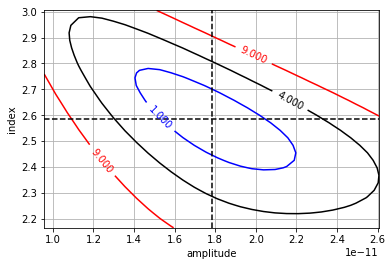

In [56]:
D = fit._iminuit_fit.draw_contour('amplitude', 'index', bins=30, show_sigma=False)
None

In [48]:
X, Y, V = D

In [49]:
V = np.array(V)
epsilon = 0.2
mask = np.where((-epsilon/2 < (V - 1)) & ((V - 1) < epsilon/2), 1, 0).astype(np.bool)

In [50]:
mask.shape
XS, YS = np.meshgrid(X, Y)
XS[mask], YS[mask]


(array([1.92413328e-11, 1.98097296e-11, 2.03781264e-11, 2.09465232e-11,
        2.15149200e-11, 2.20833168e-11, 1.75361425e-11, 2.20833168e-11,
        1.69677457e-11, 1.63993489e-11, 2.15149200e-11, 1.58309521e-11,
        1.52625553e-11, 1.81045393e-11, 1.41257618e-11, 1.75361425e-11,
        1.41257618e-11, 1.63993489e-11, 1.41257618e-11, 1.46941585e-11,
        1.52625553e-11]),
 array([2.39690155, 2.39690155, 2.39690155, 2.39690155, 2.39690155,
        2.42587062, 2.45483969, 2.45483969, 2.48380877, 2.51277784,
        2.51277784, 2.54174691, 2.59968505, 2.68659227, 2.71556134,
        2.71556134, 2.74453042, 2.74453042, 2.77349949, 2.77349949,
        2.77349949]))

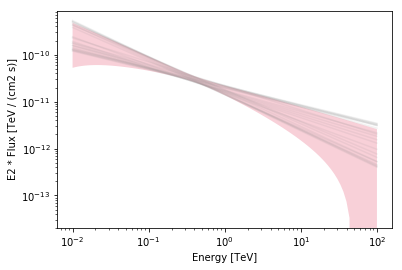

In [51]:
for amp, index in zip(XS[mask], YS[mask]):
    PowerLaw(index=index, amplitude=amp * u.Unit('TeV-1 cm-2 s-1'), ).plot(energy_range=fit.fit_range, energy_power=2, color='gray', alpha=0.1)

#fit.result[0].model.plot(fit.fit_range, energy_power=2)
fit.result[0].model.plot_error(fit.fit_range, energy_power=2, color='crimson')

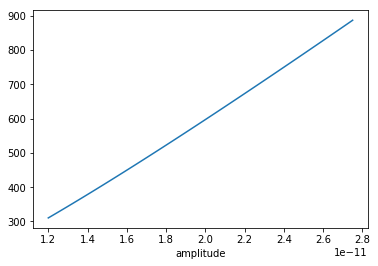

In [54]:
cmodel = fit.model.copy()
fit.plot_likelihood_1d(model=cmodel, parname='amplitude', parvals=np.linspace(1.2E-11, 2.75E-11))

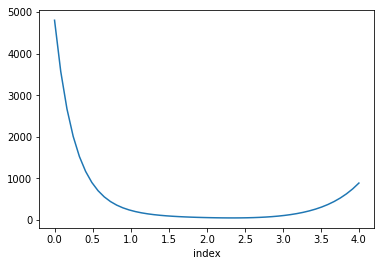

In [55]:
fit.plot_likelihood_1d(model=cmodel, parname='index', parvals=np.linspace(0, 4))